In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from google.colab import drive
# drive.mount('/content/drive')
# import pandas as pd

In [1]:
# Update this path to match your file's location in Google Drive
# file_path = '/content/drive/MyDrive/features.csv'
# df = pd.read_csv(file_path, on_bad_lines='skip')
df = pd.read_csv('features.csv', on_bad_lines='skip')
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nLabel distribution:")
print(df['label'].value_counts())
df

NameError: name 'pd' is not defined

In [ ]:
df_clean = df.dropna(subset=['energy'], how='all')

print(f"Original shape: {df.shape}, Cleaned shape: {df_clean.shape}")

Original shape: (222104, 36), Cleaned shape: (172158, 36)


In [ ]:
# Calculate signal-to-noise ratio (approximation)
df_clean['snr'] = df_clean['rms_mean'] / (df_clean['rms_std'] + 1e-10)

# Create a "vocal range" feature
df_clean['vocal_range'] = df_clean['pitch_max'] - df_clean['pitch_min']

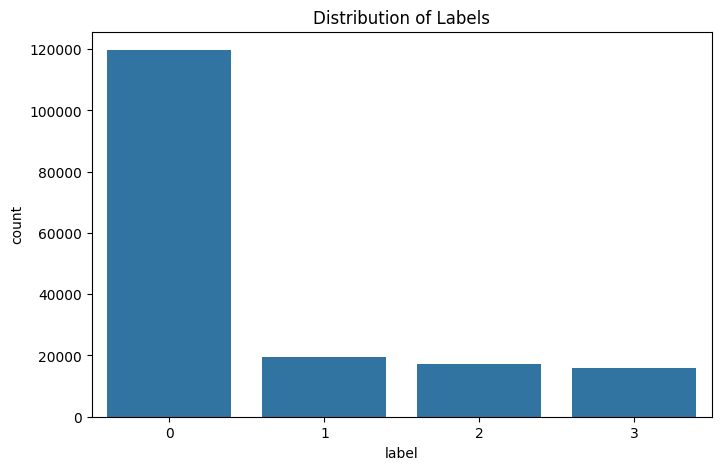

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

In [ ]:
# label_0_indices = df_clean[df_clean['label'] == 0].index[:100000]
# df_clean = df_clean.drop(label_0_indices)

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Make a copy of the original dataframe
df_balanced = df_clean.copy()

# 1. Balance 'label' categories
df_majority_1 = df_clean[df_clean.label == 0]
df_class_1 = df_clean[df_clean.label == 1]
df_class_2 = df_clean[df_clean.label == 2]
df_class_3 = df_clean[df_clean.label == 3]

n_samples_1 = len(df_majority_1)

# Upsample minority classes for 'label'
df_class_1_upsampled = resample(df_class_1, replace=True, n_samples=n_samples_1, random_state=42)
df_class_2_upsampled = resample(df_class_2, replace=True, n_samples=n_samples_1, random_state=42)
df_class_3_upsampled = resample(df_class_3, replace=True, n_samples=n_samples_1, random_state=42)

# Create balanced dataframe for 'label'
df_label_balanced = pd.concat([df_majority_1, df_class_1_upsampled, df_class_2_upsampled, df_class_3_upsampled])

# 2. Balance 'gender' categories
df_majority_2 = df_label_balanced[df_label_balanced.gender == "male"]
df_class_5 = df_label_balanced[df_label_balanced.gender == 'female']

n_samples_2 = max(len(df_majority_2), len(df_class_5))

# Upsample minority class for 'gender'
if len(df_majority_2) < len(df_class_5):
    df_majority_2 = resample(df_majority_2, replace=True, n_samples=n_samples_2, random_state=42)
else:
    df_class_5_upsampled = resample(df_class_5, replace=True, n_samples=n_samples_2, random_state=42)

# Create balanced dataframe for 'gender'
df_gender_balanced = pd.concat([df_majority_2, df_class_5_upsampled if len(df_majority_2) >= len(df_class_5) else df_class_5])

# 3. Balance 'age' categories
df_majority_3 = df_gender_balanced[df_gender_balanced.age == "twenties"]
df_class_7 = df_gender_balanced[df_gender_balanced.age == 'fifties']

n_samples_3 = max(len(df_majority_3), len(df_class_7))

# Upsample minority class for 'age'
if len(df_majority_3) < len(df_class_7):
    df_majority_3 = resample(df_majority_3, replace=True, n_samples=n_samples_3, random_state=42)
else:
    df_class_7_upsampled = resample(df_class_7, replace=True, n_samples=n_samples_3, random_state=42)

# Create final balanced dataframe
df_clean = pd.concat([df_majority_3, df_class_7_upsampled if len(df_majority_3) >= len(df_class_7) else df_class_7])

# Shuffle the dataset
df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)

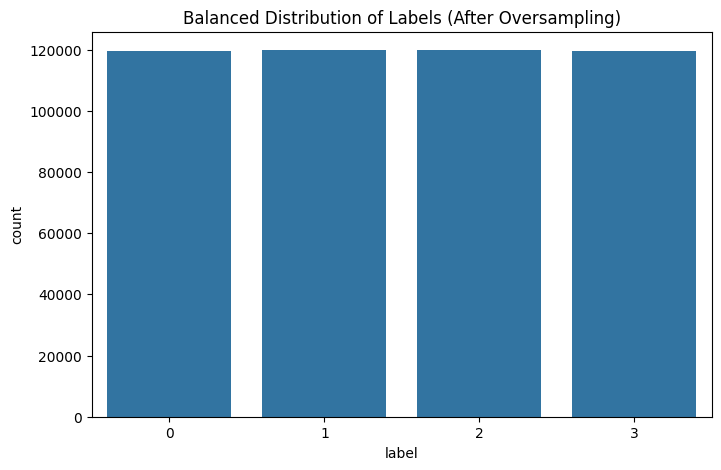

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Balanced Distribution of Labels (After Oversampling)')
plt.show()


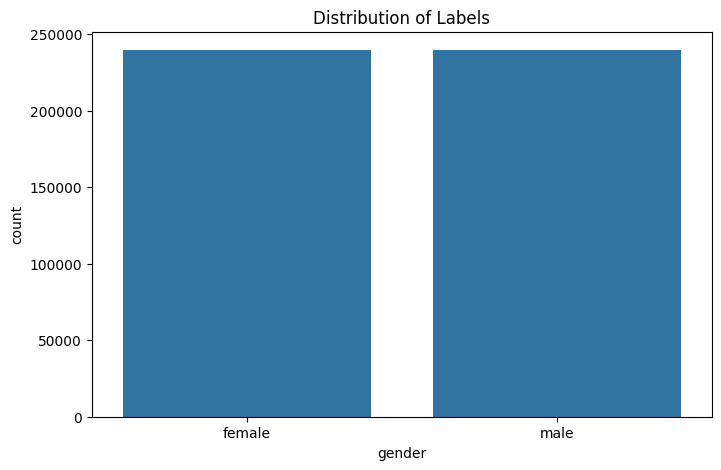

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='gender', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

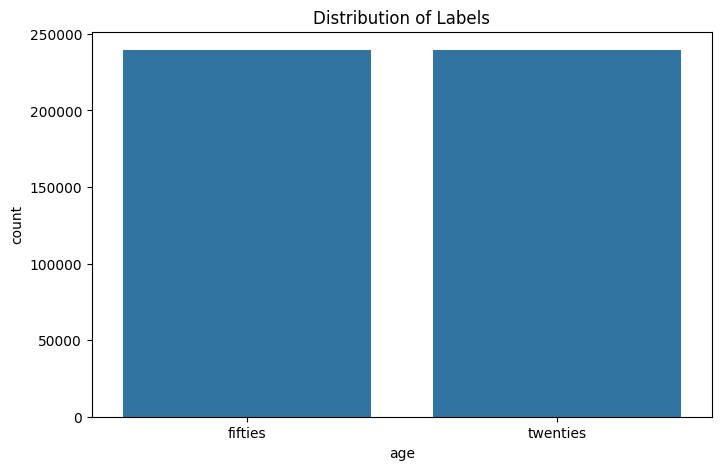

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='age', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

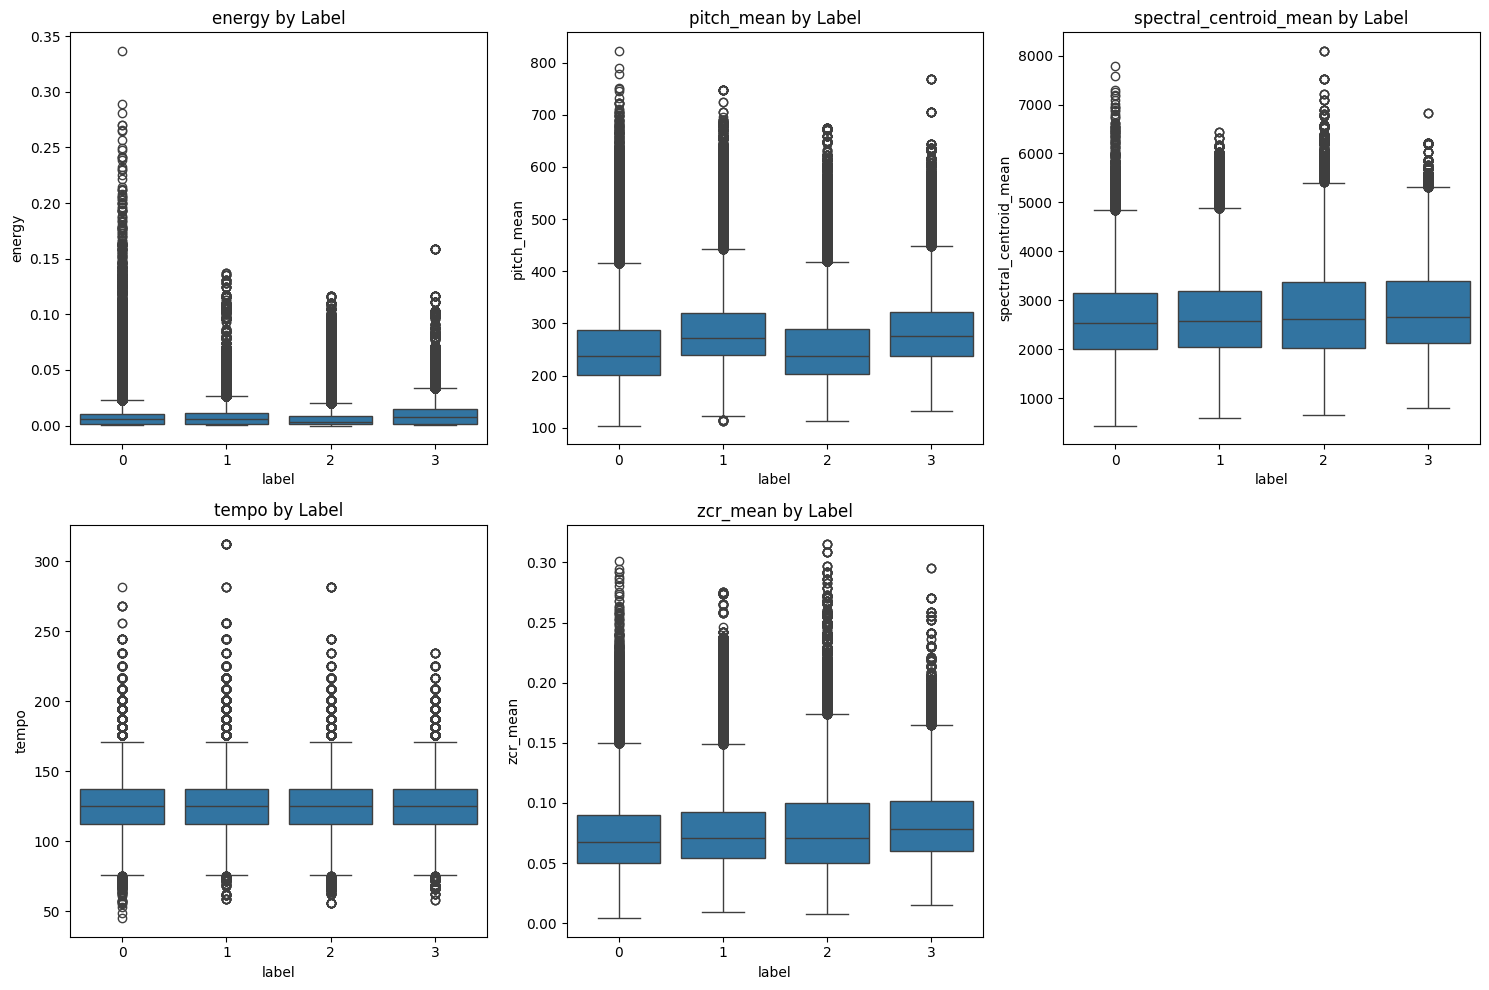

In [ ]:
features_to_plot = ['energy', 'pitch_mean', 'spectral_centroid_mean', 'tempo', 'zcr_mean']

plt.figure(figsize=(15,10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=feature, data=df_clean)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

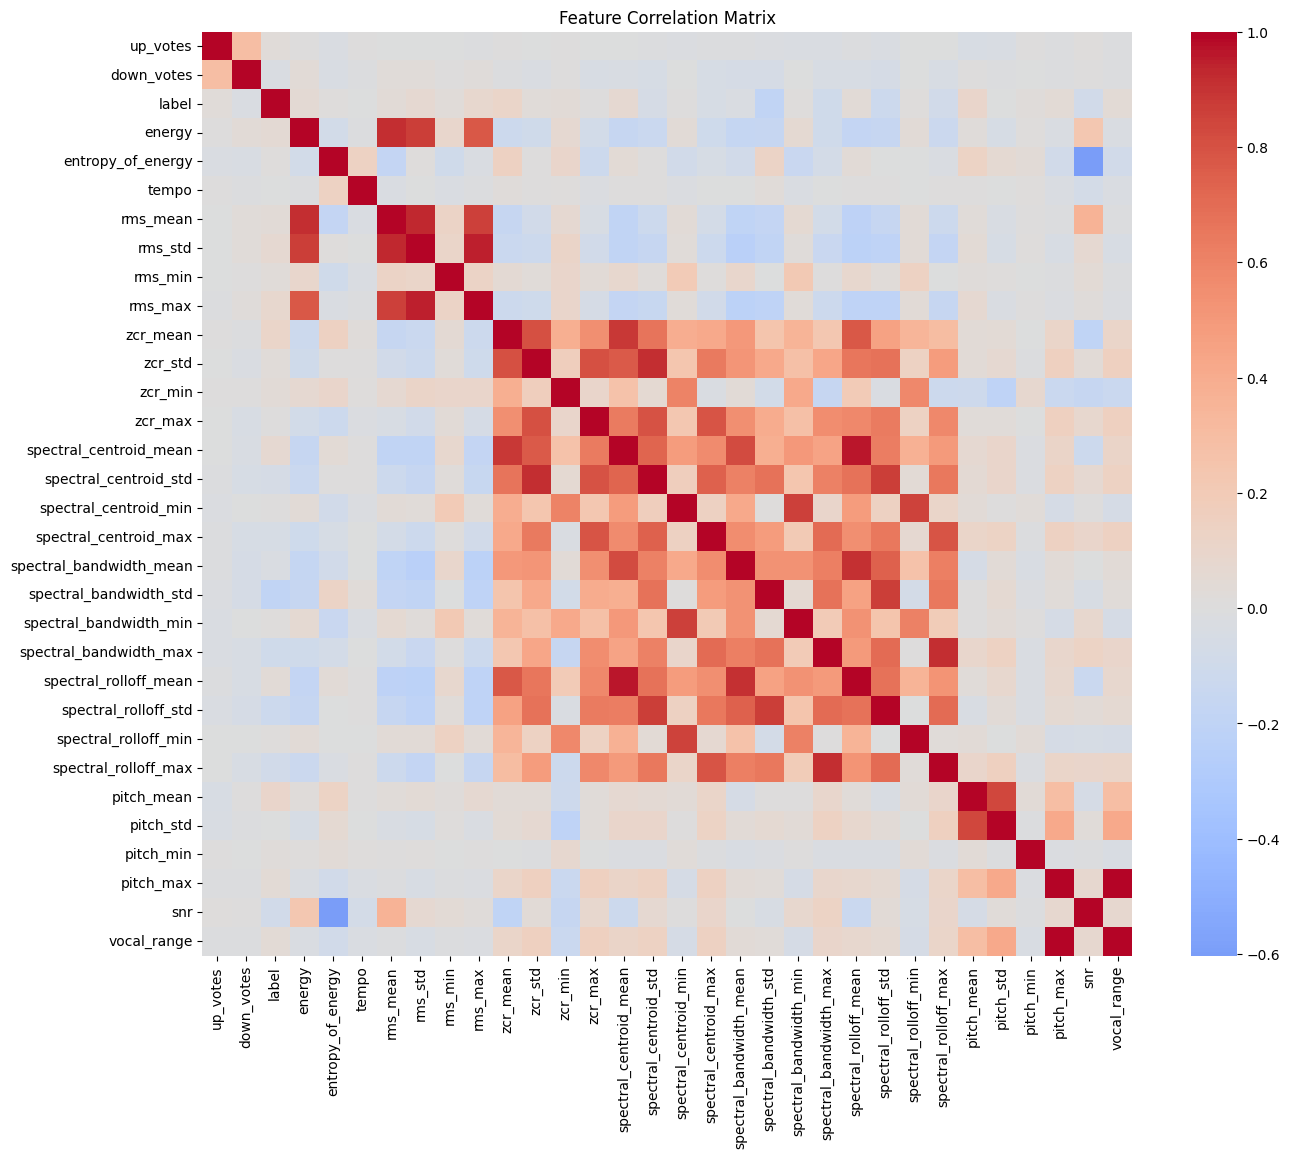

In [ ]:
# Calculate correlation matrix
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr()

# Plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
selected_features = [
    'pitch_mean',
    'pitch_std',
    'spectral_centroid_mean',
    'spectral_bandwidth_mean',
    'spectral_rolloff_mean',
    'energy'
    # 'mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13'
]

demographic_features = ['age', 'gender']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df_clean[selected_features + demographic_features]
y = df_clean['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocessing pipeline
numeric_features = selected_features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = demographic_features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
X.head()


X_train shape: (335262, 8), y_train shape: (335262,)
X_test shape: (143684, 8), y_test shape: (143684,)


,pitch_mean,pitch_std,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,energy,age,gender
0,302.006757,252.296730,2276.369441,2218.661632,4391.586330,0.005551,fifties,female
1,175.293987,150.586850,3208.622113,3283.646688,6347.256398,0.006902,fifties,male
2,253.757127,173.774122,4152.060942,3259.439296,7597.297612,0.007812,twenties,female
3,226.083971,156.379755,2481.606435,2719.251039,4662.668049,0.012552,twenties,female
4,232.086184,166.418721,3963.547688,3552.119005,7969.338389,0.000107,twenties,female


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data (using only audio features)
gender_features = X_train.drop(['age', 'gender'], axis=1)
gender_target = X_train['gender']

# Train/test split
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    gender_features, gender_target, test_size=0.3, random_state=42)

# Train model
gender_model = RandomForestClassifier()
gender_model.fit(X_train_gender, y_train_gender)

# Evaluate
print("Gender Accuracy:", gender_model.score(X_test_gender, y_test_gender))

Gender Accuracy: 0.9631235148490241


In [ ]:
age_features = X_train.drop(['age', 'gender'], axis=1)
age_target = X_train['age']

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    age_features, age_target, test_size=0.3, random_state=42)

age_model = RandomForestClassifier()
age_model.fit(X_train_age, y_train_age)

print("Age Accuracy:", age_model.score(X_test_age, y_test_age))

In [ ]:
# label_features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data
X = df_clean[selected_features + demographic_features]
y = df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ==============================================
# STEP 1: Train Demographic Predictors (Gender/Age)
# ==============================================

# Gender prediction model (using only audio features)
X_train_gender = X_train[selected_features]
y_train_gender = X_train['gender']

gender_model = RandomForestClassifier(random_state=42)
gender_model.fit(X_train_gender, y_train_gender)

# Age prediction model (using only audio features)
X_train_age = X_train[selected_features]
y_train_age = X_train['age']

age_model = RandomForestClassifier(random_state=42)
age_model.fit(X_train_age, y_train_age)

# Evaluate demographic models
print("=== Gender Model Evaluation ===")
X_test_gender = X_test[selected_features]
# print(classification_report(X_test['gender'], gender_model.predict(X_test_gender)))

print("\n=== Age Model Evaluation ===")
X_test_age = X_test[selected_features]
# print(classification_report(X_test['age'], age_model.predict(X_test_age)))

# ==============================================
# STEP 2: Apply Optimized Conditional Logic
# ==============================================

# Predict demographics for the entire test set at once
X_test_features = X_test[selected_features]
pred_genders = gender_model.predict(X_test_features)
pred_ages = age_model.predict(X_test_features)
print("Unique values in pred_genders:", np.unique(pred_genders))
print("Unique values in pred_ages:", np.unique(pred_ages))

# Initialize prediction array
y_pred = np.zeros(len(X_test), dtype=int)

# Set values based on conditions (using string values)
y_pred[(pred_genders == 'male') & (pred_ages == 'twenties')] = 0
y_pred[(pred_genders == 'female') & (pred_ages == 'twenties')] = 1
y_pred[(pred_genders == 'male') & (pred_ages == 'fifties')] = 2
y_pred[(pred_genders == 'female') & (pred_ages == 'fifties')] = 3

# Evaluate conditional logic approach
print("\n=== Conditional Logic Model Evaluation ===")
print(classification_report(y_test, y_pred))

# ==============================================
# STEP 3: Prediction Function
# ==============================================

def predict_label(audio_features):
    """Predict label from audio features using conditional logic pipeline"""
    # Convert to DataFrame if needed
    if not isinstance(audio_features, pd.DataFrame):
        audio_features = pd.DataFrame([audio_features], columns=selected_features)

    # Predict demographics for all samples at once
    pred_gender = gender_model.predict(audio_features)
    pred_age = age_model.predict(audio_features)

    # Apply conditional logic using NumPy (vectorized approach)
    result = np.zeros(len(audio_features), dtype=int)
    result[(pred_genders == 'male') & (pred_ages == 'twenties')] = 0
    result[(pred_genders == 'female') & (pred_ages == 'twenties')] = 1
    result[(pred_genders == 'male') & (pred_ages == 'fifties')] = 2
    result[(pred_genders == 'female') & (pred_ages == 'fifties')] = 3
    
    # If called with a single sample, return a scalar instead of array
    if len(result) == 1:
        return result[0]
    return result